In [9]:
from vecstack import stacking
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

#讀取資料
bank=pd.read_csv("1734final.csv")
bank = bank.drop(['Instrument','Date'],axis=1)
bank['ROI%'] = bank['ROI%'].shift(-1)

# 提取特徵欄位名稱
feature_names = bank.drop(['ROI%'], axis=1).columns.tolist()

X = bank.drop(['ROI%'],axis=1)
X=pd.DataFrame(X)
X.drop(index=X.index[-1],axis=0,inplace=True)

#資料標準化
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
X=sc.fit_transform(X)
X=pd.DataFrame(X,columns=feature_names)
static=X.describe()
#X.info()
#a=pd.DataFrame(X.corr())


predict=[]
for i in bank['ROI%']:
    if i>0:
        predict.append(1)
    else:
        False
        predict.append(0)

bank['ROI%']=predict
y=bank['ROI%']
y.drop(index=y.index[-1],axis=0,inplace=True)

#資料切割(2020/1/2前為疫情前，後為疫情後)
split_index=2452
X_train=X.iloc[:split_index]
X_test=X.iloc[split_index:]
y_train=y.iloc[:split_index]
y_test=y.iloc[split_index:]

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier
import keras.backend as K
def getRecall(y_true,y_pred):
    true_positives = tf.cast(K.sum(K.round(K.clip(y_true*y_pred, 0, 1))), tf.float32)
    possible_positives = tf.cast(K.sum(K.round(K.clip(y_true, 0, 1))), tf.float32)
    recall=true_positives/(possible_positives+K.epsilon())
    return recall

def getPrecision(y_true,y_pred):
    true_positives = tf.cast(K.sum(K.round(K.clip(y_true*y_pred, 0, 1))), tf.float32)
    predicted_positives = tf.cast(K.sum(K.round(K.clip(y_true, 0, 1))), tf.float32)

    precision=true_positives/(predicted_positives+K.epsilon())
    return precision



def create_model_s():
    model=Sequential()
    model.add(Dense(units=7,kernel_initializer='uniform',activation='relu',input_dim=45))
    model.add(Dense(units=7,kernel_initializer='uniform',activation='relu'))
    model.add(Dense(units=1,kernel_initializer='uniform',activation='sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc','mse',getRecall,getPrecision])
    return model





#Stacking
models = [
    DecisionTreeClassifier(random_state=100, min_samples_leaf=65,min_samples_split=10),

    RandomForestClassifier(random_state=100, n_estimators=10),

    XGBClassifier(random_state=100, learning_rate=0.01,max_depth=4,min_child_weight=15,n_estimators=30),

    SVC(random_state=100,kernel='rbf',gamma=0.001,C=10,probability=False),

    AdaBoostClassifier(random_state=100,n_estimators=50,learning_rate=0.001),
    
    KerasClassifier(build_fn=create_model_s,epochs=150,batch_size=1200)
]

# 儲存訓練集和測試集的預測結果列表
S_train_list = []
S_test_list = []

# 堆叠

S_train, S_test = stacking(models,
                           X_train, y_train, X_test,
                           regression=False,
                           needs_proba=False,
                           save_dir=None,
                           metric=accuracy_score,
                           n_folds=5,
                           stratified=True,
                           shuffle=True,
                           random_state=100,
                           verbose=2)

task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
mode:         [oof_pred_bag]
n_models:     [6]

model  0:     [DecisionTreeClassifier]
    fold  0:  [0.54378819]
    fold  1:  [0.52342159]
    fold  2:  [0.57959184]
    fold  3:  [0.53469388]
    fold  4:  [0.52653061]
    ----
    MEAN:     [0.54160522] + [0.02026526]
    FULL:     [0.54159869]

model  1:     [RandomForestClassifier]
    fold  0:  [0.54175153]
    fold  1:  [0.55804481]
    fold  2:  [0.56326531]
    fold  3:  [0.51428571]
    fold  4:  [0.55102041]
    ----
    MEAN:     [0.54567355] + [0.01727244]
    FULL:     [0.54567700]

model  2:     [XGBClassifier]
    fold  0:  [0.58248473]
    fold  1:  [0.58248473]
    fold  2:  [0.58367347]
    fold  3:  [0.58163265]
    fold  4:  [0.58163265]
    ----
    MEAN:     [0.58238165] + [0.00074994]
    FULL:     [0.58238173]

model  3:     [SVC]
    fold  0:  [0.58452138]
    fold  1:  [0.58655804]
    fold  2:  [0.57551020]
    fold  3:  [0.5714

C:\Users\10235\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/150
2/2 [==============================] - 1s 16ms/step - loss: 0.6931 - acc: 0.5635 - mse: 0.2500 - getRecall: 0.2354 - getPrecision: 0.2354
Epoch 2/150
2/2 [==============================] - 0s 0s/step - loss: 0.6929 - acc: 0.5824 - mse: 0.2499 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 3/150
2/2 [==============================] - 0s 0s/step - loss: 0.6927 - acc: 0.5824 - mse: 0.2498 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 4/150
2/2 [==============================] - 0s 17ms/step - loss: 0.6925 - acc: 0.5824 - mse: 0.2497 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 5/150
2/2 [==============================] - 0s 3ms/step - loss: 0.6923 - acc: 0.5824 - mse: 0.2496 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 6/150
2/2 [==============================] - 0s 13ms/step - loss: 0.6921 - acc: 0.5824 - mse: 0.2495 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 7/150
2/2 [==============================] - 0s 17ms/step -

2/2 [==============================] - 0s 13ms/step - loss: 0.6711 - acc: 0.5824 - mse: 0.2392 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 53/150
2/2 [==============================] - 0s 16ms/step - loss: 0.6709 - acc: 0.5824 - mse: 0.2391 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 54/150
2/2 [==============================] - 0s 4ms/step - loss: 0.6708 - acc: 0.5824 - mse: 0.2390 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 55/150
2/2 [==============================] - 0s 1ms/step - loss: 0.6706 - acc: 0.5824 - mse: 0.2389 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 56/150
2/2 [==============================] - 0s 1ms/step - loss: 0.6705 - acc: 0.5824 - mse: 0.2389 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 57/150
2/2 [==============================] - 0s 1ms/step - loss: 0.6703 - acc: 0.5824 - mse: 0.2388 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 58/150
2/2 [==============================] - 0s 3ms/step

2/2 [==============================] - 0s 3ms/step - loss: 0.6659 - acc: 0.5824 - mse: 0.2368 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 104/150
2/2 [==============================] - 0s 15ms/step - loss: 0.6658 - acc: 0.5824 - mse: 0.2367 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 105/150
2/2 [==============================] - 0s 14ms/step - loss: 0.6657 - acc: 0.5824 - mse: 0.2367 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 106/150
2/2 [==============================] - 0s 13ms/step - loss: 0.6656 - acc: 0.5824 - mse: 0.2366 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 107/150
2/2 [==============================] - 0s 16ms/step - loss: 0.6655 - acc: 0.5824 - mse: 0.2366 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 108/150
2/2 [==============================] - 0s 17ms/step - loss: 0.6654 - acc: 0.5824 - mse: 0.2366 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 109/150
2/2 [==============================] - 0s

C:\Users\10235\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 [==============================] - 1s 9ms/step - loss: 0.6932 - acc: 0.4742 - mse: 0.2500 - getRecall: 0.5093 - getPrecision: 0.5093
Epoch 2/150
2/2 [==============================] - 0s 10ms/step - loss: 0.6930 - acc: 0.5824 - mse: 0.2499 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 3/150
2/2 [==============================] - 0s 15ms/step - loss: 0.6928 - acc: 0.5824 - mse: 0.2498 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 4/150
2/2 [==============================] - 0s 14ms/step - loss: 0.6926 - acc: 0.5824 - mse: 0.2497 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 5/150
2/2 [==============================] - 0s 15ms/step - loss: 0.6924 - acc: 0.5824 - mse: 0.2496 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 6/150
2/2 [==============================] - 0s 15ms/step - loss: 0.6922 - acc: 0.5824 - mse: 0.2495 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 7/150
2/2 [==============================] - 0s 17ms/step - loss: 0

2/2 [==============================] - 0s 0s/step - loss: 0.6733 - acc: 0.5829 - mse: 0.2402 - getRecall: 0.0015 - getPrecision: 0.0015     
Epoch 53/150
2/2 [==============================] - 0s 14ms/step - loss: 0.6731 - acc: 0.5844 - mse: 0.2401 - getRecall: 0.0068 - getPrecision: 0.0068
Epoch 54/150
2/2 [==============================] - 0s 0s/step - loss: 0.6729 - acc: 0.5839 - mse: 0.2400 - getRecall: 0.0062 - getPrecision: 0.0062
Epoch 55/150
2/2 [==============================] - 0s 16ms/step - loss: 0.6727 - acc: 0.5844 - mse: 0.2400 - getRecall: 0.0067 - getPrecision: 0.0067
Epoch 56/150
2/2 [==============================] - 0s 2ms/step - loss: 0.6726 - acc: 0.5844 - mse: 0.2399 - getRecall: 0.0125 - getPrecision: 0.0125
Epoch 57/150
2/2 [==============================] - 0s 15ms/step - loss: 0.6724 - acc: 0.5849 - mse: 0.2398 - getRecall: 0.0146 - getPrecision: 0.0146
Epoch 58/150
2/2 [==============================] - 0s 17ms/step - loss: 0.6723 - acc: 0.5849 - mse: 0.2397

2/2 [==============================] - 0s 17ms/step - loss: 0.6651 - acc: 0.5992 - mse: 0.2363 - getRecall: 0.1980 - getPrecision: 0.1980
Epoch 107/150
2/2 [==============================] - 0s 15ms/step - loss: 0.6650 - acc: 0.6002 - mse: 0.2362 - getRecall: 0.1972 - getPrecision: 0.1972
Epoch 108/150
2/2 [==============================] - 0s 2ms/step - loss: 0.6649 - acc: 0.6002 - mse: 0.2362 - getRecall: 0.1923 - getPrecision: 0.1923
Epoch 109/150
2/2 [==============================] - 0s 0s/step - loss: 0.6647 - acc: 0.6017 - mse: 0.2361 - getRecall: 0.2077 - getPrecision: 0.2077
Epoch 110/150
2/2 [==============================] - 0s 0s/step - loss: 0.6646 - acc: 0.6017 - mse: 0.2360 - getRecall: 0.2026 - getPrecision: 0.2026
Epoch 111/150
2/2 [==============================] - 0s 14ms/step - loss: 0.6644 - acc: 0.6017 - mse: 0.2360 - getRecall: 0.1939 - getPrecision: 0.1939
Epoch 112/150
2/2 [==============================] - 0s 17ms/step - loss: 0.6643 - acc: 0.6017 - mse: 0.235

C:\Users\10235\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 [==============================] - 1s 17ms/step - loss: 0.6931 - acc: 0.5540 - mse: 0.2500 - getRecall: 0.0765 - getPrecision: 0.0765
Epoch 2/150
2/2 [==============================] - 0s 14ms/step - loss: 0.6929 - acc: 0.5821 - mse: 0.2499 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 3/150
2/2 [==============================] - 0s 16ms/step - loss: 0.6928 - acc: 0.5821 - mse: 0.2498 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 4/150
2/2 [==============================] - 0s 15ms/step - loss: 0.6926 - acc: 0.5821 - mse: 0.2497 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 5/150
2/2 [==============================] - 0s 13ms/step - loss: 0.6923 - acc: 0.5821 - mse: 0.2496 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 6/150
2/2 [==============================] - 0s 17ms/step - loss: 0.6922 - acc: 0.5821 - mse: 0.2495 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 7/150
2/2 [==============================] - 0s 2ms/step - loss: 0

2/2 [==============================] - 0s 10ms/step - loss: 0.6730 - acc: 0.5821 - mse: 0.2401 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 53/150
2/2 [==============================] - 0s 18ms/step - loss: 0.6728 - acc: 0.5821 - mse: 0.2400 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 54/150
2/2 [==============================] - 0s 4ms/step - loss: 0.6726 - acc: 0.5821 - mse: 0.2400 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 55/150
2/2 [==============================] - 0s 9ms/step - loss: 0.6725 - acc: 0.5821 - mse: 0.2399 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 56/150
2/2 [==============================] - 0s 10ms/step - loss: 0.6723 - acc: 0.5821 - mse: 0.2398 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 57/150
2/2 [==============================] - 0s 17ms/step - loss: 0.6722 - acc: 0.5821 - mse: 0.2397 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 58/150
2/2 [==============================] - 0s 14ms/s

2/2 [==============================] - 0s 9ms/step - loss: 0.6661 - acc: 0.5821 - mse: 0.2370 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 104/150
2/2 [==============================] - 0s 9ms/step - loss: 0.6660 - acc: 0.5821 - mse: 0.2369 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 105/150
2/2 [==============================] - 0s 9ms/step - loss: 0.6658 - acc: 0.5821 - mse: 0.2368 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 106/150
2/2 [==============================] - 0s 9ms/step - loss: 0.6657 - acc: 0.5821 - mse: 0.2368 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 107/150
2/2 [==============================] - 0s 8ms/step - loss: 0.6655 - acc: 0.5821 - mse: 0.2367 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 108/150
2/2 [==============================] - 0s 5ms/step - loss: 0.6654 - acc: 0.5821 - mse: 0.2366 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 109/150
2/2 [==============================] - 0s 8ms/

C:\Users\10235\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 [==============================] - 1s 19ms/step - loss: 0.6931 - acc: 0.5657 - mse: 0.2500 - getRecall: 0.1370 - getPrecision: 0.1370
Epoch 2/150
2/2 [==============================] - 0s 0s/step - loss: 0.6929 - acc: 0.5826 - mse: 0.2499 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 3/150
2/2 [==============================] - 0s 17ms/step - loss: 0.6927 - acc: 0.5826 - mse: 0.2498 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 4/150
2/2 [==============================] - 0s 5ms/step - loss: 0.6924 - acc: 0.5826 - mse: 0.2497 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 5/150
2/2 [==============================] - 0s 16ms/step - loss: 0.6922 - acc: 0.5826 - mse: 0.2495 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 6/150
2/2 [==============================] - 0s 3ms/step - loss: 0.6920 - acc: 0.5826 - mse: 0.2494 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 7/150
2/2 [==============================] - 0s 15ms/step - loss: 0.69

2/2 [==============================] - 0s 13ms/step - loss: 0.6717 - acc: 0.5826 - mse: 0.2395 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 53/150
2/2 [==============================] - 0s 0s/step - loss: 0.6716 - acc: 0.5826 - mse: 0.2394 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 54/150
2/2 [==============================] - 0s 0s/step - loss: 0.6715 - acc: 0.5826 - mse: 0.2394 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 55/150
2/2 [==============================] - 0s 0s/step - loss: 0.6713 - acc: 0.5826 - mse: 0.2393 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 56/150
2/2 [==============================] - 0s 0s/step - loss: 0.6712 - acc: 0.5826 - mse: 0.2392 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 57/150
2/2 [==============================] - 0s 14ms/step - loss: 0.6711 - acc: 0.5826 - mse: 0.2392 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 58/150
2/2 [==============================] - 0s 13ms/step - 

2/2 [==============================] - 0s 13ms/step - loss: 0.6643 - acc: 0.5826 - mse: 0.2360 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 104/150
2/2 [==============================] - 0s 17ms/step - loss: 0.6641 - acc: 0.5826 - mse: 0.2359 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 105/150
2/2 [==============================] - 0s 13ms/step - loss: 0.6639 - acc: 0.5826 - mse: 0.2358 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 106/150
2/2 [==============================] - 0s 5ms/step - loss: 0.6637 - acc: 0.5826 - mse: 0.2357 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 107/150
2/2 [==============================] - 0s 0s/step - loss: 0.6635 - acc: 0.5826 - mse: 0.2356 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 108/150
2/2 [==============================] - 0s 14ms/step - loss: 0.6634 - acc: 0.5826 - mse: 0.2355 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 109/150
2/2 [==============================] - 0s 1

C:\Users\10235\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 [==============================] - 1s 16ms/step - loss: 0.6931 - acc: 0.5122 - mse: 0.2500 - getRecall: 0.2831 - getPrecision: 0.2831
Epoch 2/150
2/2 [==============================] - 0s 16ms/step - loss: 0.6929 - acc: 0.5826 - mse: 0.2499 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 3/150
2/2 [==============================] - 0s 0s/step - loss: 0.6927 - acc: 0.5826 - mse: 0.2498 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 4/150
2/2 [==============================] - 0s 16ms/step - loss: 0.6925 - acc: 0.5826 - mse: 0.2497 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 5/150
2/2 [==============================] - 0s 16ms/step - loss: 0.6923 - acc: 0.5826 - mse: 0.2496 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 6/150
2/2 [==============================] - 0s 0s/step - loss: 0.6921 - acc: 0.5826 - mse: 0.2495 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 7/150
2/2 [==============================] - 0s 16ms/step - loss: 0.69

2/2 [==============================] - 0s 16ms/step - loss: 0.6721 - acc: 0.5826 - mse: 0.2397 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 53/150
2/2 [==============================] - 0s 0s/step - loss: 0.6720 - acc: 0.5826 - mse: 0.2396 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 54/150
2/2 [==============================] - 0s 0s/step - loss: 0.6719 - acc: 0.5826 - mse: 0.2396 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 55/150
2/2 [==============================] - 0s 9ms/step - loss: 0.6718 - acc: 0.5826 - mse: 0.2395 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 56/150
2/2 [==============================] - 0s 17ms/step - loss: 0.6717 - acc: 0.5826 - mse: 0.2395 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 57/150
2/2 [==============================] - 0s 15ms/step - loss: 0.6716 - acc: 0.5826 - mse: 0.2395 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 58/150
2/2 [==============================] - 0s 17ms/step

2/2 [==============================] - 0s 16ms/step - loss: 0.6664 - acc: 0.5826 - mse: 0.2370 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 104/150
2/2 [==============================] - 0s 16ms/step - loss: 0.6662 - acc: 0.5826 - mse: 0.2370 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 105/150
2/2 [==============================] - 0s 16ms/step - loss: 0.6661 - acc: 0.5826 - mse: 0.2369 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 106/150
2/2 [==============================] - 0s 0s/step - loss: 0.6660 - acc: 0.5826 - mse: 0.2369 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 107/150
2/2 [==============================] - 0s 0s/step - loss: 0.6659 - acc: 0.5826 - mse: 0.2368 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 108/150
2/2 [==============================] - 0s 16ms/step - loss: 0.6657 - acc: 0.5826 - mse: 0.2367 - getRecall: 0.0000e+00 - getPrecision: 0.0000e+00
Epoch 109/150
2/2 [==============================] - 0s 16

1/1 [==============================] - 0s 31ms/step
    fold  4:  [0.58367347]
    ----
    MEAN:     [0.58727628] + [0.00519349]
    FULL:     [0.58727569]



In [10]:

print('S_train:',S_train)
print('S_test:',S_test)

S_train: [[1 0 0 0 1 0]
 [1 1 0 0 1 0]
 [1 0 0 0 1 0]
 ...
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 0 0 0 0 0]]
S_test: [[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 1 0]
 ...
 [0 1 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]


訓練集準確率: 0.5856443719412724
測試集準確率: 0.5341130604288499
集成模型混淆矩陣:
 [[540   6]
 [472   8]]


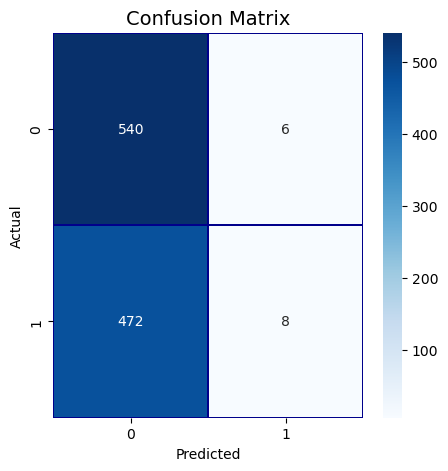

              precision    recall  f1-score   support

           0       0.53      0.99      0.69       546
           1       0.57      0.02      0.03       480

    accuracy                           0.53      1026
   macro avg       0.55      0.50      0.36      1026
weighted avg       0.55      0.53      0.38      1026

Logistic Regression coefficients:
[-0.00470341 -0.01540564  0.         -0.43332145  0.4332938   0.36480482]
Logistic Regression intercept:
[-0.44235341]


In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
# 使用Logistic來評估特徵的重要性
model_svm=linear_model.LogisticRegression(C=10,penalty='l2',solver='liblinear',random_state=20240420)
model_svm=model_svm.fit(S_train,y_train)

test_prob=model_svm.predict(S_test)
test_prob.shape

#計算模型準確率
accuracy_train = model_svm.score(S_train, y_train)
accuracy_test = model_svm.score(S_test, y_test)
print('訓練集準確率:', accuracy_train)
print('測試集準確率:', accuracy_test)

from sklearn.metrics import confusion_matrix

# 混淆矩陣
y_pred = model_svm.predict(S_test)
cm = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
fig, ax1 = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm,
           xticklabels=['0','1'],
           yticklabels=['0','1'],
           annot=True, fmt='g', ax=ax1,
           linewidths=.2, linecolor='Darkblue', cmap='Blues'
           )
print('集成模型混淆矩陣:\n', confusion_matrix(y_test, y_pred))
plt.title('Confusion Matrix', fontsize=14)
plt.show()

#混淆矩陣指標
from sklearn.metrics import classification_report,confusion_matrix, roc_curve, auc
y_pred=model_svm.predict(S_test)
print(classification_report(y_test, y_pred, zero_division=0))

y_pred=model_svm.predict(S_test)
y_pred_proba=model_svm.predict_proba(S_test)[:,1]
[fpr,tpr,thr]=roc_curve(y_test,y_pred_proba)
idx=np.min(np.where(tpr>0.95))

idx2=np.min(np.where(tpr>0.90))

auc(fpr,tpr)

# 顯示Logistic Regression模型的係數
print("Logistic Regression coefficients:")
coefficients = model_svm.coef_[0]
print(coefficients)

# 顯示截距
print("Logistic Regression intercept:")
print(model_svm.intercept_)
